In [1]:
import qiskit
from qiskit import QuantumCircuit, BasicAer, Aer, transpile
import qiskit.providers.aer.library
from qiskit.quantum_info import random_statevector
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.opflow import I, X, Y, Z
from qiskit.algorithms.optimizers import ADAM
from qiskit.circuit import ParameterVector
from qiskit.algorithms import VQE

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

from random import random
import numpy as np
from statistics import mean
from scipy.optimize import minimize
from tqdm import tqdm
import itertools

In [2]:
def add_layers(circuit, params):
    
    for p in range(0, len(params), 3):
        
        beta = params[p]
        theta = params[p + 1]
        gamma = params[p + 2]
        
        circuit.rxx(beta,14,15)
        circuit.rxx(beta,6,7)
        circuit.rxx(beta,0,8)
        circuit.rxx(beta,1,9)
        circuit.rxx(beta,13,5)
        circuit.rxx(beta,12,4)
        circuit.rxx(beta,3,2)
        circuit.rxx(beta,11,10)
        circuit.barrier()
        circuit.ryy(theta,15,7)
        circuit.ryy(theta,14,6)
        circuit.ryy(theta,8,9)
        circuit.ryy(theta,0,1)
        circuit.ryy(theta,5,4)
        circuit.ryy(theta,13,2)
        circuit.ryy(theta,2,10)
        circuit.ryy(theta,3,11)
        circuit.barrier()
        circuit.rzz(gamma,15,12)
        circuit.rzz(gamma,6,5)
        circuit.rzz(gamma,1,2)
        circuit.rzz(gamma,8,11)
        circuit.barrier()
        circuit.rzz(gamma,7,0)
        circuit.rzz(gamma,9,14)
        circuit.rzz(gamma,3,4)
        circuit.rzz(gamma,10,13)
        circuit.barrier()
        
    return circuit

In [3]:
def create_state_vector(num_qubits, params):
    
    circuit = QuantumCircuit(num_qubits)
    
    #initialize state
    for i in range(0, num_qubits):
        circuit.h(i)
    circuit.barrier()
    
    add_layers(circuit, params)
    circuit.save_statevector()
        
    simulator = Aer.get_backend('qasm_simulator')    
    result = simulator.run(circuit).result()
    statevector = result.get_statevector(circuit)
    
    return statevector

In [4]:
def create_circuit(num_qubits, params):
    
    circuit = QuantumCircuit(num_qubits)
    
    #initialize state
    for i in range(0, num_qubits):
        circuit.h(i)
    circuit.barrier()
    
    add_layers(circuit, params)
    
    return circuit

In [5]:
def create_random_param(depth):
    
    params = []
    for _ in range(depth * 3):
        params.append(random() * 2 * np.pi)
        
    return params

In [6]:
def schmidt_spectrum(state):
    
    matrix = np.array(state).reshape(int(np.sqrt(len(state))), int(np.sqrt(len(state))))
    u, vector, v = np.linalg.svd(matrix)
    return vector

In [7]:
#Made by Anirban
def Haar(num_qubits):
    
    #defining a random n qubit Haar random state
    state=random_statevector(2**num_qubits).data
    amplitudes = state
    bit_arr = [list(i) for i in itertools.product([0, 1], repeat = num_qubits)]
    bitStr_arr=[''.join([str(bit_arr[i][j]) for j in range(len(bit_arr[i]))]) for i in range(len(bit_arr))]
    #String rep. for the random state
    Psi=[bitStr_arr[i] + ',' + str(amplitudes[i]) for i in range(len(amplitudes)) if np.abs(amplitudes[i]) > 1e-5]
    return Psi, state

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


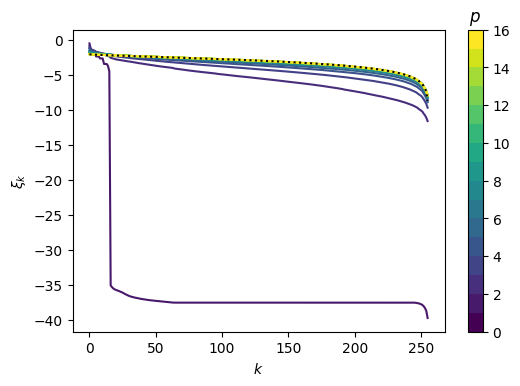

In [50]:
#"""""""""""""""""""""" Graph config """""""""""""""""""#
colors = plt.cm.viridis(np.linspace(0,1,17))
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\xi_k$')
norm = mpl.colors.BoundaryNorm(list(range(17)), plt.cm.viridis.N)
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
clb = fig.colorbar(scalar_mappable)
clb.ax.set_title(r'$p$')
#""""""""""""""""""""""""""""""""""""""""""""""""""""""#

num_qubits = 16
iterations = 100
depth_range = range(1,num_qubits + 1)

for depth in tqdm(depth_range):
    all_es = []
    for _ in range(iterations):
        random_param = create_random_param(depth)
        state = create_state_vector(num_qubits, random_param)
        schmidt_coeffs = schmidt_spectrum(state)
        all_es.append(np.log(schmidt_coeffs))
    mean_es = np.array(all_es, dtype=object).mean(axis=0)
    ax.plot(mean_es, linestyle='solid', markersize=2, color=colors[depth])

all_haar = []
for i in tqdm(range(iterations)):
    Psi,state=Haar(num_qubits)
    schmidt_coefficients=schmidt_spectrum(state)
    spectrum=np.log(schmidt_coefficients)
    all_haar.append(spectrum)
mean_haar = np.array(all_haar, dtype=object).mean(axis=0)
ax.plot(mean_haar, linestyle='dotted', color='#000000', markersize=2)
    
plt.show()

In [38]:
def expectation_value(counts, shots):
    
    def eigenvalue_mapping(bit):
        return 1 if int(bit) == 1 else -1
        
    energies = []

    #Go through every repetition
    for key, value in counts.items():
        energy = 0     
        #boundary condition
        leftmost = key[0]
        rightmost = key[len(key) - 1]
        energy += eigenvalue_mapping(leftmost) * eigenvalue_mapping(rightmost)

        #go through each bitstring, bit-by-bit
        for j in range(len(key) - 1):
            left = key[j]
            right = key[j+1]

            #add each count of this bitstring
            for k in range(value):
                energy += eigenvalue_mapping(left) * eigenvalue_mapping(right)
        energies.append(energy)
        
    return np.sum(energies) / shots

In [41]:
def cost_function(params):
    
    num_qubits = 16
    shots = 5000
    simulator = Aer.get_backend('aer_simulator')

    # Z basis measurement
    circuit = create_circuit(num_qubits, params)  
    circuit.measure_all()
#     circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots = shots).result()
    counts = result.get_counts(circuit)
    z_exp_value = expectation_value(counts, shots)

    # X basis measurement
    circuit = create_circuit(num_qubits, params)
    for i in range(num_qubits):
        circuit.h(i)
    circuit.measure_all()
#     circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots = shots).result()
    counts = result.get_counts(circuit)
    x_exp_value = expectation_value(counts, shots)
    
    # Y basis measurement
    circuit = create_circuit(num_qubits, params)
    for i in range(num_qubits):
        circuit.sdg(i)
        circuit.h(i)
    circuit.measure_all()
#     circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots = shots).result()
    counts = result.get_counts(circuit)
    y_exp_value = expectation_value(counts, shots)
    
    exp_value = -z_exp_value - x_exp_value - y_exp_value
        
    return exp_value

In [8]:
hamiltonian = \
(I^I^I^I^I^I^I^I^I^I^I^I^I^I^X^X) + \
(I^I^I^I^I^I^X^X^I^I^I^I^I^I^I^I) + \
(X^I^I^I^I^I^I^I^X^I^I^I^I^I^I^I) + \
(I^X^I^I^I^I^I^I^I^X^I^I^I^I^I^I) + \
(I^I^I^I^I^X^I^I^I^I^I^I^I^X^I^I)+ \
(I^I^I^I^X^I^I^I^I^I^I^I^X^I^I^I) + \
(I^I^X^X^I^I^I^I^I^I^I^I^I^I^I^I) + \
(I^I^I^I^I^I^I^I^I^I^X^X^I^I^I^I) + \
(I^I^I^I^I^I^I^Y^I^I^I^I^I^I^I^Y) + \
(I^I^I^I^I^I^Y^I^I^I^I^I^I^I^Y^I) + \
(I^I^I^I^I^I^I^I^Y^Y^I^I^I^I^I^I) + \
(Y^Y^I^I^I^I^I^I^I^I^I^I^I^I^I^I) + \
(I^I^I^I^Y^Y^I^I^I^I^I^I^I^I^I^I) + \
(I^I^Y^I^I^I^I^I^I^I^I^I^I^Y^I^I) + \
(I^I^Y^I^I^I^I^I^I^I^Y^I^I^I^I^I) + \
(I^I^I^Y^I^I^I^I^I^I^I^Y^I^I^I^I) + \
(I^I^I^I^I^I^I^I^I^I^I^I^Z^I^I^Z) + \
(I^I^I^I^I^Z^Z^I^I^I^I^I^I^I^I^I) + \
(I^I^I^I^I^I^I^I^Z^I^I^Z^I^I^I^I) + \
(I^Z^Z^I^I^I^I^I^I^I^I^I^I^I^I^I) + \
(Z^I^I^I^I^I^Z^I^I^I^I^I^I^I^I^I) + \
(I^I^I^I^I^I^I^I^I^Z^I^I^I^I^Z^I) + \
(I^I^I^Z^Z^I^I^I^I^I^I^I^I^I^I^I) + \
(I^I^I^I^I^I^I^I^I^I^Z^I^I^Z^I^I)

In [18]:
seed = algorithm_globals.random_seed
quant_inst = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=8192, seed_transpiler=seed, seed_simulator=seed)

depth = 2
qubits = 16
optimizer = ADAM(maxiter=3000,tol=0.0001, lr=0.001)
initial = create_random_param(depth)
ansatz = create_circuit(qubits, ParameterVector('p',depth*3))
vqe = VQE(ansatz = ansatz, optimizer = optimizer, initial_point = initial, quantum_instance=quant_inst)
result = vqe.compute_minimum_eigenvalue(operator = hamiltonian)
print(result)

KeyboardInterrupt: 

In [10]:
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn

In [17]:
num_shots = 1024
backend = Aer.get_backend('qasm_simulator',seed=10)
q_instance=QuantumInstance(backend,shots=num_shots) 
circ=create_circuit(16, [1,1,1])
psi = CircuitStateFn(circ)
op = hamiltonian
measurable_expression = StateFn(op, is_measurement=True).compose(psi) 
expectation = PauliExpectation().convert(measurable_expression) 
sampler = CircuitSampler(q_instance).convert(expectation) 
MSE=PauliExpectation().compute_variance(sampler)/q_instance.run_config.shots

TypeError: Unsupported primitive type <class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'> passed into StateFn factory constructor